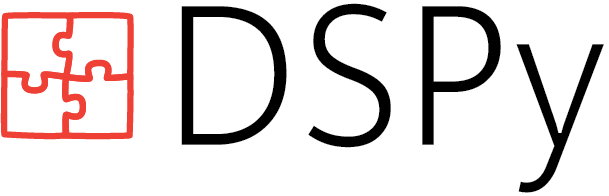

In the **DSPy** framework, the primary data type utilized for interactions with various modules `Example`. Given the huge repository of datasets available through Hugging Face, there's a significant opportunity to leverage these resources within DSPy. However, to make these datasets compatible and fully utilizable, they need to be converted into the `Example` data format.

Moreover, CSV files are a common format for storing and exchanging data, recognized for their simplicity and wide application across various domains. The conversion of data from CSV format into the `Example` format is a necessary requirement. But can we we do something to avoid this tedious process?

Introducing `DataLoaders`, a module aimed at simplifying the task of importing dataset from diverse sources, including HuggingFace and CSV files, into the `Example` format. `DataLoaders` are designed to abstract away the complexities and boilerplate involved in data conversion, offering a user-friendly interface for loading, transforming, and preparing data for use within the DSPy framework. This addition significantly enhances the ease of use of DSPy.

# Setting Up

In [ ]:
%load_ext autoreload
%autoreload 2

import sys
import os

try: # When on google Colab, let's clone the notebook so we download the cache.
    import google.colab  # noqa: F401
    repo_path = 'dspy'
    !git -C $repo_path pull origin || git clone https://github.com/stanfordnlp/dspy $repo_path
except:
    repo_path = '.'

if repo_path not in sys.path:
    sys.path.append(repo_path)

# Set up the cache for this notebook
os.environ["DSP_NOTEBOOK_CACHEDIR"] = os.path.join(repo_path, 'cache')

import pkg_resources # Install the package if it's not installed
if "dspy-ai" not in {pkg.key for pkg in pkg_resources.working_set}:
    !pip install -U pip
    # !pip install dspy-ai
    !pip install -e $repo_path

# Data Loading Using `DataLoader`

Currently `DataLoader` provides support for data loading for following sources:

* HuggingFace using `from_huggingface()` method.
* CSV Files using `from_csv()` method.

We'll start by initializing the `DataLoader` object that takes no arguments, so we can just create an object without arguments.

In [12]:
from dspy.datasets import DataLoader

dl = DataLoader()

## Loading from HuggingFace

To load data from Hugging Face we have `from_huggingface` method which loads a dataset from Hugging Face's datasets library and processes it according to the split configuration.

**Parameters:**
* `dataset_name (str)`: The name of the dataset to load.
* `*args`: Positional arguments passed to the load_dataset function.
* `input_keys (Tuple[str], optional)`: Tuple of input keys to be used in the dataset.
* `fields (Tuple[str], optional)`: Tuple of fields to include from the dataset. If None, all fields are included.
* `**kwargs`: Keyword arguments passed to the load_dataset function.

**Returns:**

* A dictionary mapping split names to lists of `dspy.Example` objects, or a list of `dspy.Example` objects if split is a string.

In [25]:
code_alpaca = dl.from_huggingface(
    "HuggingFaceH4/CodeAlpaca_20K",
    split = ["train", "test"], # returns Dictionary with train, test keys
    input_keys = ("prompt",),
)

Once the above code is executed the data would be returned in a dict with keys `train`, and `test` each containing the List of `Example` for each split based on the dataset:

In [26]:
print(f"Keys present in the returned dict: {list(code_alpaca.keys())}")

print(f"Number of examples in train set: {len(code_alpaca['train'])}")
print(f"Number of examples in test set: {len(code_alpaca['test'])}")

Keys present in the returned dict: ['train', 'test']
Number of examples in train set: 18019
Number of examples in test set: 2003


You can also pass a single split or a read instruction or anything that `load_dataset` allows you to pass and the conversion to `dspy.Example` would be taken care of by Dataloader.

In [27]:
code_alpaca = dl.from_huggingface(
    "HuggingFaceH4/CodeAlpaca_20K",
    split = "train",
)

print(f"Number of examples in split: {len(code_alpaca)}")

Number of examples in split: 18019


As you can see if the `split` argumnent is a string it will return a List of `dspy.Example` instead of mapping because there is only one split in it. However, HF Dataset can create slices of dataset too and the same concept can be applied here too!

In [28]:
code_alpaca_80 = dl.from_huggingface(
    "HuggingFaceH4/CodeAlpaca_20K",
    split = "train[:80%]",
)

print(f"Number of examples in split: {len(code_alpaca_80)}")

code_alpaca_20_80 = dl.from_huggingface(
    "HuggingFaceH4/CodeAlpaca_20K",
    split = "train[20%:80%]",
)

print(f"Number of examples in split: {len(code_alpaca_20_80)}")

Number of examples in split: 14415
Number of examples in split: 10811


Cool right! In the same way we can use `ReadInstruction` to create even more complicated splits. That aside, if you need to load a dataset from a subset(if any) you can pass it as a positional argument to the method. Similar to how you do it in `load_dataset`.

In [29]:
gms8k = dl.from_huggingface(
    "gsm8k",
    "main",
    input_keys = ("question",),
)

print(f"Keys present in the returned dict: {list(gms8k.keys())}")

print(f"Number of examples in train set: {len(gms8k['train'])}")
print(f"Number of examples in test set: {len(gms8k['test'])}")

Keys present in the returned dict: ['train', 'test']
Number of examples in train set: 7473
Number of examples in test set: 1319


## Loading from CSV

The from_csv function in the DataLoader class makes it easy to load data from CSV files for machine learning projects. You just need to tell it where your CSV file is and which parts of the data you're interested in by listing the columns you want. This function turns your CSV data into a list of examples that you can use right away with DSPy modules.

**Parameters:**
* `file_path (str)`: The path to the CSV file.
* `fields (List[str], optional)`: List of fields to include from the dataset. If None, all fields are included.
* `input_keys (Tuple[str], optional)`: Tuple of input keys to be used in the dataset.

**Returns:**
* A list of `dspy.Example` objects.

In [24]:
dolly_100_dataset = dl.from_csv(
    "dolly_subset_100_rows.csv",
    fields=["instruction", "context", "response"],
)

Once the above code is executed the data would be returned in a dict with keys `train`, `dev`, and `test` containing the List of `Example` for each split based on the configuration of size and seed set in the object during initialization

In [10]:
print(f"Number of examples in train set: {len(dolly_100_dataset)}")

Number of examples in train set: 100


In [11]:
dolly_100_dataset[-1]

Example({'instruction': 'Which of these animals can be pets? Wolf, dog, rabbit, squirrel, cat, lion.', 'context': None, 'response': 'While most animals can be domesticated, dogs, rabbits and cats are common pets.'}) (input_keys={()})

# Manipulating Dataset with `DataLoader`

## Sampling Chunks

To sample chunks of data from your dataset, you can use the sample method of the DataLoader class. This method allows you to randomly pick a specified number of examples from your dataset. For example, if you want to sample 5 examples from a dataset `gsm8k` we loaded above, you can use the following code:

In [32]:
sampled_example = dl.sample(dataset=gms8k["train"], n=5)

print(f"Number of examples in sampled chunk: {len(sampled_example)}")

Number of examples in sampled chunk: 5


This will give you a random set of 5 examples from `gms8k` dataset's `train` split that you can use for quick testing or analysis.

## Splitting Dataset

To split your dataset into training and testing sets, the DataLoader class provides the `train_test_split` method. This method divides your dataset based on the proportions you specify. For instance, if you have a dataset `dolly_100_dataset` and you want to split it with 80% of the data for training and 20% for testing, you can use the code like this:

In [34]:
splits = dl.train_test_split(dataset=dolly_100_dataset, train_size=0.8)
train_dataset = splits['train']
test_dataset = splits['test']

print(f"Number of total examples in dataset: {len(dolly_100_dataset)}")
print(f"Number of examples in train set: {len(train_dataset)}")
print(f"Number of examples in test set: {len(test_dataset)}")

Number of total examples in dataset: 100
Number of examples in train set: 80
Number of examples in test set: 20


Now, `train_dataset` will contain 80% of the examples for training your model, and `test_dataset` will contain the remaining 20% for testing its performance.